        ts_code trade_date    open    high     low   close  pre_close  change  \
0     002594.SZ   20230428  261.47  262.97  254.00  255.86     258.92   -3.06   
1     002594.SZ   20230427  250.00  258.99  249.55  258.92     251.00    7.92   
2     002594.SZ   20230426  243.00  254.54  241.00  251.00     244.30    6.70   
3     002594.SZ   20230425  251.00  251.80  242.20  244.30     253.49   -9.19   
4     002594.SZ   20230424  244.10  258.60  243.18  253.49     243.00   10.49   
...         ...        ...     ...     ...     ...     ...        ...     ...   
1045  002594.SZ   20190108   52.30   53.64   52.05   52.88      51.39    1.49   
1046  002594.SZ   20190107   50.85   51.88   50.00   51.39      50.65    0.74   
1047  002594.SZ   20190104   47.80   51.00   47.51   50.65      48.06    2.59   
1048  002594.SZ   20190103   49.26   49.87   47.98   48.06      49.17   -1.11   
1049  002594.SZ   20190102   51.02   51.39   48.98   49.17      51.00   -1.83   

      pct_chg        vol   

/Users/zhangwenbo/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/zhangwenbo/miniforge3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/var/folders/g3/764mx2lj2gs3qc7l4pz4v2n00000gp/T/ipykernel_77484/3447584973.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = forecast['Prediction']


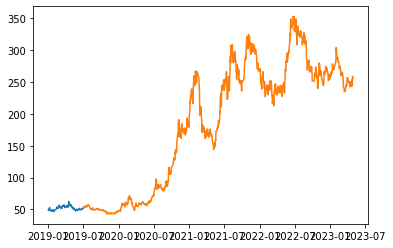

In [6]:
# 自回归积分滑动平均模型
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
from pmdarima import auto_arima
ts.set_token('b0030b7297c6b297f1db549c7f8c8a080b5f28e2267f07c4741e69ad')

class AutoARIMA_pridict:
    stock_code = ''
    tsData = pd.DataFrame()
    def __init__(self, stock_code):
        self.stock_code = stock_code
    def date_setting(self, start_date, end_date):
        pro = ts.pro_api()
        self.tsData = pro.daily(ts_code=self.stock_code, start_date=start_date, end_date=end_date)
        print(self.tsData)
        self.tsData = self.tsData.reset_index()
    def makePredictionByDay(self, node): # 按日回测
        new_data = pd.DataFrame(index=range(0, len(self.tsData)), columns=['Date', 'Close'])
        for i in range(0, len(self.tsData)):
            new_data['Date'][i] = self.tsData['trade_date'][i]
            new_data['Close'][i] = self.tsData['close'][i]
        new_data['Date'] = pd.to_datetime(new_data.Date, format='%Y-%m-%d')
        new_data.index = new_data['Date']
        # 准备数据
        new_data = new_data.sort_index(ascending=True)
        forecast = []
        # 训练集和预测集
        prediction = new_data[node:]
        for i in range(0, len(new_data) - node):
            train = new_data[:node + i]
            valid = new_data[node + i:]
            # 对收盘价进行测试
            training = train['Close']
            validation = valid['Close']
            # 拟合模型
            model = auto_arima(training, start_p=1, start_q=1, max_p=2, max_q=2, m=12, start_P=0, seasonal=True, d=1,
                               D=1,
                               trace=True, error_action='ignore', suppress_warnings=True)  #
            model.fit(training)
            # 预测
            forecast.append(model.predict(n_periods=1)[0])
        prediction['Prediction'] = forecast
        plt.plot(train['Close'])
        plt.plot(prediction[['Close', 'Prediction']])
        plt.show()
    def makePrediction(self, node): # node为节点天数，在这之前为训练集、之后为测试集，
        new_data = pd.DataFrame(index=range(0, len(self.tsData)), columns=['Date', 'Close'])
        for i in range(0, len(self.tsData)):
            new_data['Date'][i] = self.tsData['trade_date'][i]
            new_data['Close'][i] = self.tsData['close'][i]
        new_data['Date'] = pd.to_datetime(new_data.Date, format='%Y-%m-%d')
        new_data.index = new_data['Date']
        # 准备数据
        new_data = new_data.sort_index(ascending=True)
        # 训练集和预测集
        train = new_data[:node]
        valid = new_data[node:]
        # 对收盘价进行测试
        training = train['Close']
        validation = valid['Close']
        # 拟合模型
        model = auto_arima(training, start_p=1, start_q=1, max_p=2, max_q=2, m=12, start_P=0, seasonal=True, d=1, D=1,
                           trace=True, error_action='ignore', suppress_warnings=True)#
        model.fit(training)
        # 进行预测
        forecast = model.predict(n_periods=len(valid))
        forecast = pd.DataFrame(forecast, index=valid.index, columns=['Prediction'])
        # 画图
        valid['Predictions'] = forecast['Prediction']
        plt.plot(train['Close'], label = '训练集')
        plt.plot(valid[['Close', 'Predictions']], label = ['真实值', '预测值'])
        plt.show()

a = AutoARIMA_pridict('002594.SZ')
a.date_setting(start_date='20190101', end_date='20230431')
a.makePrediction(120)